## Run infomap

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
from ipywidgets import Checkbox, VBox, Button, Output, IntSlider, HBox, HTML
from IPython.display import display
from tqdm.notebook import tqdm

!pip install infomap

# Load connection data
df = pd.read_csv("connections_princeton.csv")
nt_types = sorted(df['nt_type'].dropna().unique())

# Configuration parameters
top_n_modules = 100  # Change this number to control how many top communities to show
last_combo_name = None  # global placeholder
last_selected_nts = None

# Create checkboxes for neurotransmitter types
checkboxes = [Checkbox(value=False, description=nt) for nt in nt_types]
checkbox_box = VBox(checkboxes)

# Create edge threshold slider
# First, let's get some statistics about the data to set reasonable bounds
edge_stats = df.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum()
min_connections = int(edge_stats.min())
max_connections = int(edge_stats.max())
median_connections = int(edge_stats.median())

threshold_slider = IntSlider(
    value=1,  # Default threshold
    min=min_connections,
    max=min(max_connections, 10),  # Cap at 100 for practical UI purposes
    step=1,
    description='Min Synapses:',
    style={'description_width': 'initial'},
    continuous_update=False
)

# Add some helpful statistics display
stats_html = HTML(
    value=f"""
    <div style='font-size: 12px; color: #666; margin: 10px 0;'>
    <b>Connection Statistics:</b><br>
    Min: {min_connections}, Median: {median_connections}, Max: {max_connections}<br>
    Total unique edges: {len(edge_stats):,}
    </div>
    """
)

# Function to update statistics when threshold changes
def update_stats(change):
    threshold = change['new']
    edges_above_threshold = (edge_stats >= threshold).sum()
    percentage_kept = (edges_above_threshold / len(edge_stats)) * 100
    
    stats_html.value = f"""
    <div style='font-size: 12px; color: #666; margin: 10px 0;'>
    <b>Connection Statistics:</b><br>
    Min: {min_connections}, Median: {median_connections}, Max: {max_connections}<br>
    Total unique edges: {len(edge_stats):,}<br>
    <b>With threshold {threshold}:</b> {edges_above_threshold:,} edges ({percentage_kept:.1f}%)
    </div>
    """

threshold_slider.observe(update_stats, names='value')

# Button to generate Pajek files + run Infomap
run_button = Button(description="Run Infomap", button_style='success')
output = Output()

def make_pajek_file(df, nt_types, outname, min_synapses=1):
    """
    Create a Pajek file from connection data with edge filtering.
    
    Parameters:
    df: DataFrame with connection data
    nt_types: List of neurotransmitter types to include
    outname: Output filename for the Pajek file
    min_synapses: Minimum number of synapses required for an edge (threshold)
    """
    # Filter by neurotransmitter types
    nt_df = df[df['nt_type'].isin(nt_types)]
    
    # Group by pre/post root IDs and sum synaptic connections
    edges = (
        nt_df.groupby(['pre_root_id', 'post_root_id'])['syn_count']
        .sum()
        .reset_index()
        .rename(columns={'pre_root_id': 'source', 'post_root_id': 'target', 'syn_count': 'weight'})
    )
    
    # Apply threshold filter - this creates the sparse connectivity matrix
    edges = edges[edges['weight'] >= min_synapses]
    
    if len(edges) == 0:
        raise ValueError(f"No edges remain after applying threshold of {min_synapses} synapses. Try a lower threshold.")
    
    # Get all unique nodes from the filtered edges
    all_nodes = pd.Index(edges['source'].tolist() + edges['target'].tolist()).unique()
    node_to_id = {node: idx + 1 for idx, node in enumerate(all_nodes)}
    
    # Write Pajek file
    with open(outname, "w") as f:
        f.write(f"*Vertices {len(all_nodes)}\n")
        for node in all_nodes:
            f.write(f'{node_to_id[node]} "{node}"\n')
        f.write("*Edges\n")
        for _, row in edges.iterrows():
            f.write(f"{node_to_id[row['source']]} {node_to_id[row['target']]} {row['weight']}\n")
    
    return len(edges), len(all_nodes)

def run_infomap(input_file, output_dir):
    """Run Infomap clustering algorithm."""
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    cmd = [
        "infomap", input_file, output_dir,
         "--num-trials", "5"
    ]
    
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    if result.returncode != 0:
        raise RuntimeError(f"Infomap error:\n{result.stderr}")
    return result.stdout

# Button callback
def on_button_clicked(b):
    global last_combo_name, last_selected_nts
    output.clear_output()
    
    selected_nts = [cb.description for cb in checkboxes if cb.value]
    if not selected_nts:
        with output:
            print("⚠️ Please select at least one neurotransmitter.")
        return
    
    threshold = threshold_slider.value
    
    with output:
        print(f"⚙️ Processing {len(selected_nts)} neurotransmitter(s) with threshold ≥{threshold} synapses...")
        print(f"Selected: {', '.join(selected_nts)}")
    
    try:
        combo_name = "_".join(sorted(nt.lower() for nt in selected_nts))
        outdir = f"output_{combo_name}_thresh{threshold}"
        pajek_file = f"{outdir}/{combo_name}_thresh{threshold}_graph.net"
        
        os.makedirs(outdir, exist_ok=True)
        
        # Create pajek file with threshold
        num_edges, num_nodes = make_pajek_file(df, nt_types=selected_nts, outname=pajek_file, min_synapses=threshold)
        
        with output:
            print(f"📊 Graph created: {num_nodes} nodes, {num_edges} edges")
            print(f"🔄 Running Infomap...")
        
        result = run_infomap(pajek_file, outdir)
        
        last_combo_name = combo_name
        last_selected_nts = selected_nts
        
        with output:
            print(f"✅ Infomap complete!")
            print(f"📁 Output directory: {outdir}")
            print(f"🧠 Neurotransmitters: {', '.join(selected_nts)}")
            print(f"🎯 Synapse threshold: ≥{threshold}")
            print(f"📈 Final network: {num_nodes} nodes, {num_edges} edges")
            
    except Exception as e:
        with output:
            print(f"❌ Error: {e}")

run_button.on_click(on_button_clicked)

# Create the GUI layout
parameter_box = VBox([
    HTML("<h3>Neurotransmitter Selection</h3>"),
    checkbox_box,
    HTML("<h3>Edge Threshold (Sparse Matrix)</h3>"),
    HTML("<p style='font-size: 12px; color: #666;'>Set minimum number of synaptic connections required for an edge to be included.</p>"),
    threshold_slider,
    stats_html
])

# Display GUI
display(VBox([parameter_box, run_button, output]))

## Visualize

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os
from ipywidgets import RadioButtons, VBox, Output
from IPython.display import display

# ====== STEP 0: Check neurotransmitters selected ======
try:
    last_selected_nts  = ['gaba']
    selected_nts = last_selected_nts
    print(f"✓ Using neurotransmitters: {selected_nts}")
except NameError:
    raise ValueError("⚠️ Please run the Infomap step first by clicking the button.")

# ====== STEP 1: Define file paths ======
nt_clean = "_".join(sorted(nt.lower() for nt in selected_nts))

# Get the threshold value
try:
    threshold = threshold_slider.value
except NameError:
    threshold = 1  # Default fallback

# Build the correct paths
output_dir = f"output_{nt_clean}_thresh{threshold}"
tree_file = f"{output_dir}/{nt_clean}_thresh{threshold}_graph.tree"
coords_file = "coordinates.csv"
pajek_file = f"{output_dir}/{nt_clean}_thresh{threshold}_graph.net"

# ====== STEP 2: Build node ID to root ID mapping from Pajek ======
id_to_node = {}
with open(pajek_file, "r") as f:
    for line in f:
        if line.startswith("*Vertices"):
            continue
        if line.startswith("*Edges"):
            break
        parts = line.strip().split()
        if len(parts) >= 2:
            id_num = int(parts[0])
            root_id = parts[1].strip('"')
            id_to_node[id_num] = root_id

# ====== STEP 3: Parse .tree file ======
tree_data = []
with open(tree_file, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split()
        if len(parts) >= 2:
            module_path = parts[0]
            node_index = int(parts[-1])
            root_id = str(id_to_node.get(node_index, "UNKNOWN"))
            tree_data.append((root_id, module_path))

modules_df = pd.DataFrame(tree_data, columns=["neuron_id", "module_path"])

# Extract level 1 and level 2 module assignments
modules_df["level_1"] = modules_df["module_path"].str.split(":").str[0].astype(int)
modules_df["level_2"] = modules_df["module_path"].apply(
    lambda x: int(x.split(":")[1]) if ":" in x else np.nan
)

# ====== STEP 4: Merge with coordinates ======
positions_df = pd.read_csv(coords_file)
positions_df["neuron_id"] = positions_df["root_id"].astype(str)
merged = pd.merge(modules_df, positions_df, on="neuron_id")

# Convert "[x y z]" string to numeric columns
merged[["x", "y", "z"]] = merged["position"].apply(
    lambda s: pd.Series(np.fromstring(s.strip("[]"), sep=" "))
)

# ====== STEP 5: Create interactive toggle and plot function ======
def create_plot(level_choice):
    """Create plot based on level selection"""
    fig = go.Figure()
    min_module_size = 11  # Minimum neurons required for a module to be displayed
    
    if level_choice == "Level 1":
        # Plot Level 1 modules with size filter
        level_1_counts = merged["level_1"].value_counts()
        large_modules = level_1_counts[level_1_counts >= min_module_size].index
        level_1_modules = sorted(large_modules)
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        
        for i, module in enumerate(level_1_modules):
            cluster = merged[merged["level_1"] == module]
            color = colors[i % len(colors)]
            fig.add_trace(go.Scatter3d(
                x=cluster["x"],
                y=cluster["y"],
                z=cluster["z"],
                mode='markers',
                marker=dict(size=3, opacity=0.7, color=color),
                name=f"Module {module}",
                hovertemplate=f"Module {module}<br>Neurons: {len(cluster)}<br>X: %{{x}}<br>Y: %{{y}}<br>Z: %{{z}}<extra></extra>"
            ))
        
        total_modules = len(merged["level_1"].dropna().unique())
        filtered_modules = len(level_1_modules)
        title = f"Level 1 Modules ({filtered_modules}/{total_modules} modules ≥{min_module_size} neurons)"
        
    else:  # Level 2
        # Plot Level 2 modules with size filter
        level_2_counts = merged["level_2"].value_counts()
        large_modules = level_2_counts[level_2_counts >= min_module_size].index
        level_2_modules = sorted(large_modules)
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
        
        for i, module in enumerate(level_2_modules):
            cluster = merged[merged["level_2"] == module]
            color = colors[i % len(colors)]
            fig.add_trace(go.Scatter3d(
                x=cluster["x"],
                y=cluster["y"],
                z=cluster["z"],
                mode='markers',
                marker=dict(size=3, opacity=0.7, color=color),
                name=f"Module {module}",
                hovertemplate=f"Module {module}<br>Neurons: {len(cluster)}<br>X: %{{x}}<br>Y: %{{y}}<br>Z: %{{z}}<extra></extra>"
            ))
        
        total_modules = len(merged["level_2"].dropna().unique())
        filtered_modules = len(level_2_modules)
        title = f"Level 2 Modules ({filtered_modules}/{total_modules} modules ≥{min_module_size} neurons)"
    
    # Update layout
    fig.update_layout(
        title=f"Infomap {title}<br>NTs: {', '.join(selected_nts)}, Threshold: ≥{threshold}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y', 
            zaxis_title='Z',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        legend_title="Modules",
        width=1000,
        height=800,
        margin=dict(l=0, r=0, b=0, t=80)
    )
    
    return fig

# Create radio button toggle
level_toggle = RadioButtons(
    options=['Level 1', 'Level 2'],
    value='Level 1',
    description='Show:',
    style={'description_width': 'initial'}
)

plot_output = Output()

def on_level_change(change):
    """Update plot when toggle changes"""
    with plot_output:
        plot_output.clear_output(wait=True)
        fig = create_plot(change['new'])
        fig.show()

# Set up the callback
level_toggle.observe(on_level_change, names='value')

# Display initial plot
with plot_output:
    fig = create_plot('Level 1')
    fig.show()

# Display the interface
display(VBox([level_toggle, plot_output]))

✓ Using neurotransmitters: ['gaba']


FileNotFoundError: [Errno 2] No such file or directory: 'output_gaba_thresh1/gaba_thresh1_graph.net'

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os
from ipywidgets import RadioButtons, VBox, Output, Dropdown
from IPython.display import display

# ====== STEP 0: Check neurotransmitters selected ======
try:
    selected_nts = last_selected_nts
    print(f"✓ Using neurotransmitters: {selected_nts}")
except NameError:
    raise ValueError("⚠️ Please run the Infomap step first by clicking the button.")

# ====== STEP 1: Define file paths ======
nt_clean = "_".join(sorted(nt.lower() for nt in selected_nts))

# Get the threshold value
try:
    threshold = threshold_slider.value
except NameError:
    threshold = 5  # Default fallback

# Build the correct paths
output_dir = f"output_{nt_clean}_thresh{threshold}"
tree_file = f"{output_dir}/{nt_clean}_thresh{threshold}_graph.tree"
coords_file = "coordinates.csv"
pajek_file = f"{output_dir}/{nt_clean}_thresh{threshold}_graph.net"
classification_file = "classification.csv"

# ====== STEP 2: Build node ID to root ID mapping from Pajek ======
id_to_node = {}
with open(pajek_file, "r") as f:
    for line in f:
        if line.startswith("*Vertices"):
            continue
        if line.startswith("*Edges"):
            break
        parts = line.strip().split()
        if len(parts) >= 2:
            id_num = int(parts[0])
            root_id = parts[1].strip('"')
            id_to_node[id_num] = root_id

# ====== STEP 3: Parse .tree file ======
tree_data = []
with open(tree_file, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split()
        if len(parts) >= 2:
            module_path = parts[0]
            node_index = int(parts[-1])
            root_id = str(id_to_node.get(node_index, "UNKNOWN"))
            tree_data.append((root_id, module_path))

modules_df = pd.DataFrame(tree_data, columns=["neuron_id", "module_path"])

# Extract level 1 and level 2 module assignments
modules_df["level_1"] = modules_df["module_path"].str.split(":").str[0].astype(int)
modules_df["level_2"] = modules_df["module_path"].apply(
    lambda x: int(x.split(":")[1]) if ":" in x else np.nan
)

# ====== STEP 4: Merge with coordinates ======
positions_df = pd.read_csv(coords_file)
positions_df["neuron_id"] = positions_df["root_id"].astype(str)
merged = pd.merge(modules_df, positions_df, on="neuron_id")

# Convert "[x y z]" string to numeric columns
merged[["x", "y", "z"]] = merged["position"].apply(
    lambda s: pd.Series(np.fromstring(s.strip("[]"), sep=" "))
)

# ====== STEP 5: Merge with classification data ======
try:
    classification_df = pd.read_csv(classification_file)
    classification_df["neuron_id"] = classification_df["root_id"].astype(str)
    
    # Clean up empty strings and convert to NaN for consistency
    classification_df = classification_df.replace('', np.nan)
    
    # DEBUG: Check ID format matching
    print("=== DEBUGGING ID MATCHING ===")
    print(f"Sample connectome neuron IDs: {list(merged['neuron_id'].head())}")
    print(f"Sample classification root IDs: {list(classification_df['neuron_id'].head())}")
    print(f"Connectome ID format: {type(merged['neuron_id'].iloc[0])}")
    print(f"Classification ID format: {type(classification_df['neuron_id'].iloc[0])}")
    
    # Check for matches before merge
    connectome_ids = set(merged['neuron_id'])
    classification_ids = set(classification_df['neuron_id'])
    matches = connectome_ids.intersection(classification_ids)
    print(f"Total connectome neurons: {len(connectome_ids)}")
    print(f"Total classification entries: {len(classification_ids)}")
    print(f"Matching IDs: {len(matches)}")
    
    if len(matches) == 0:
        print("❌ NO MATCHING IDs FOUND!")
        print("This suggests the ID formats don't match between files.")
        print("Let's try some common fixes...")
        
        # Try different ID format conversions
        # Option 1: Maybe root_ids in classification need to be strings
        classification_df["neuron_id"] = classification_df["root_id"].astype(str)
        
        # Option 2: Maybe connectome IDs are actually root_ids from positions
        merged_alt = merged.copy()
        merged_alt["neuron_id"] = merged_alt["root_id"].astype(str)  # Use root_id instead
        
        # Check again
        connectome_ids_alt = set(merged_alt['neuron_id'])
        matches_alt = connectome_ids_alt.intersection(classification_ids)
        print(f"Trying root_id match: {len(matches_alt)} matches")
        
        if len(matches_alt) > len(matches):
            merged = merged_alt
            matches = matches_alt
            print("✓ Using root_id for matching")
    
    # Merge with classification data
    merged = pd.merge(merged, classification_df, on="neuron_id", how="left")
    
    # Count successful matches
    matched_neurons = merged['flow'].notna().sum()
    print(f"✓ Successfully matched {matched_neurons}/{len(merged)} neurons ({matched_neurons/len(merged)*100:.1f}%)")
    
    if matched_neurons > 0:
        print(f"✓ Available classification columns: {[col for col in classification_df.columns if col != 'neuron_id']}")
        print(f"✓ Flow types: {merged['flow'].value_counts().to_dict()}")
        print(f"✓ Super classes: {merged['super_class'].value_counts().to_dict()}")
        print(f"✓ Classes: {merged['class'].value_counts().head().to_dict()}")
        print(f"✓ Sides: {merged['side'].value_counts().to_dict()}")
    else:
        print("❌ No successful matches - all neurons will show as 'unknown'")
        print(f"Sample connectome IDs: {list(merged['neuron_id'].head(3))}")
        print(f"Sample classification IDs: {list(classification_df['neuron_id'].head(3))}")
    
except FileNotFoundError:
    print("⚠️ classification.csv not found - proceeding without classification data")
    # Add dummy columns
    for col in ['flow', 'super_class', 'class', 'sub_class', 'hemilineage', 'side', 'nerve']:
        merged[col] = 'unknown'

# ====== STEP 6: Analysis functions ======
def analyze_module_composition(df, module_col, classification_col):
    """Analyze the composition of modules by classification"""
    composition = {}
    
    for module in sorted(df[module_col].dropna().unique()):
        module_data = df[df[module_col] == module]
        
        # Count classifications in this module
        class_counts = module_data[classification_col].value_counts()
        total = len(module_data)
        
        composition[module] = {
            'total_neurons': total,
            'classifications': class_counts.to_dict(),
            'top_class': class_counts.index[0] if len(class_counts) > 0 else 'unknown',
            'diversity': len(class_counts)  # Number of different classifications
        }
    
    return composition

def create_plot(level_choice, color_by='module'):
    """Create plot based on level selection and coloring scheme"""
    fig = go.Figure()
    min_module_size = 5
    
    if level_choice == "Level 1":
        # Plot Level 1 modules with size filter
        level_1_counts = merged["level_1"].value_counts()
        large_modules = level_1_counts[level_1_counts >= min_module_size].index
        level_1_modules = sorted(large_modules)
        module_col = "level_1"
        
    else:  # Level 2
        # Plot Level 2 modules with size filter
        level_2_counts = merged["level_2"].value_counts()
        large_modules = level_2_counts[level_2_counts >= min_module_size].index
        level_2_modules = sorted(large_modules)
        module_col = "level_2"
    
    # Color schemes
    module_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    # Expanded classification colors
    classification_colors = {
        # Flow types
        'intrinsic': '#1f77b4',
        'afferent': '#ff7f0e', 
        'efferent': '#2ca02c',
        'ascending': '#d62728',
        'descending': '#9467bd',
        # Super classes
        'optic': '#ff4444',
        'sensory': '#44ff44',
        'motor': '#4444ff',
        'central_brain': '#ff44ff',
        # Classes
        'visual': '#ffaa44',
        'photo_receptor': '#44aaff',
        'optic_lobe_intrinsic': '#aa44ff',
        # Sides
        'left': '#ff6b6b',
        'right': '#4ecdc4',
        # Default
        'unknown': '#7f7f7f'
    }
    
    # Generate colors for any classification values not in our predefined list
    def get_color_for_value(value, color_dict, base_colors):
        if pd.isna(value):
            return '#7f7f7f'
        if value in color_dict:
            return color_dict[value]
        # Generate color based on hash of the value
        hash_val = hash(str(value)) % len(base_colors)
        return base_colors[hash_val]
    
    if color_by == 'module':
        # Color by module
        for i, module in enumerate(large_modules):
            cluster = merged[merged[module_col] == module]
            color = module_colors[i % len(module_colors)]
            
            # Get composition info for hover
            if 'super_class' in merged.columns:
                top_class = cluster['super_class'].value_counts().index[0] if len(cluster) > 0 else 'unknown'
                class_diversity = len(cluster['super_class'].value_counts())
            else:
                top_class = 'unknown'
                class_diversity = 0
            
            fig.add_trace(go.Scatter3d(
                x=cluster["x"],
                y=cluster["y"],
                z=cluster["z"],
                mode='markers',
                marker=dict(size=3, opacity=0.7, color=color),
                name=f"Module {module}",
                hovertemplate=f"Module {module}<br>Neurons: {len(cluster)}<br>Top class: {top_class}<br>Diversity: {class_diversity}<br>X: %{{x}}<br>Y: %{{y}}<br>Z: %{{z}}<extra></extra>"
            ))
            
    else:  # Color by classification
        # Get all neurons in large modules
        large_module_neurons = merged[merged[module_col].isin(large_modules)]
        
        # Get unique values for this classification, excluding NaN
        unique_values = large_module_neurons[color_by].dropna().unique()
        
        for class_value in unique_values:
            subset = large_module_neurons[large_module_neurons[color_by] == class_value]
            color = get_color_for_value(class_value, classification_colors, module_colors)
            
            fig.add_trace(go.Scatter3d(
                x=subset["x"],
                y=subset["y"],
                z=subset["z"],
                mode='markers',
                marker=dict(size=3, opacity=0.7, color=color),
                name=f"{class_value}",
                hovertemplate=f"{color_by}: {class_value}<br>Module: %{{customdata}}<br>Neurons: {len(subset)}<br>X: %{{x}}<br>Y: %{{y}}<br>Z: %{{z}}<extra></extra>",
                customdata=subset[module_col]
            ))
        
        # Also handle NaN values if they exist
        nan_subset = large_module_neurons[large_module_neurons[color_by].isna()]
        if len(nan_subset) > 0:
            fig.add_trace(go.Scatter3d(
                x=nan_subset["x"],
                y=nan_subset["y"],
                z=nan_subset["z"],
                mode='markers',
                marker=dict(size=3, opacity=0.3, color='#cccccc'),
                name="unclassified",
                hovertemplate=f"{color_by}: unclassified<br>Module: %{{customdata}}<br>Neurons: {len(nan_subset)}<br>X: %{{x}}<br>Y: %{{y}}<br>Z: %{{z}}<extra></extra>",
                customdata=nan_subset[module_col]
            ))
    
    # Title and stats
    total_modules = len(merged[module_col].dropna().unique()) if level_choice == "Level 1" else len(merged["level_2"].dropna().unique())
    filtered_modules = len(large_modules)
    level_name = level_choice
    
    title = f"{level_name} Modules ({filtered_modules}/{total_modules} modules ≥{min_module_size} neurons)"
    if color_by != 'module':
        title += f"<br>Colored by {color_by}"
    
    # Update layout
    fig.update_layout(
        title=f"Infomap {title}<br>NTs: {', '.join(selected_nts)}, Threshold: ≥{threshold}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y', 
            zaxis_title='Z',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        legend_title="Legend",
        width=1000,
        height=800,
        margin=dict(l=0, r=0, b=0, t=100)
    )
    
    return fig

# ====== STEP 7: Create interactive interface ======
# Level toggle
level_toggle = RadioButtons(
    options=['Level 1', 'Level 2'],
    value='Level 1',
    description='Module Level:',
    style={'description_width': 'initial'}
)

# Color scheme dropdown
available_class_cols = ['flow', 'super_class', 'class', 'sub_class', 'side']
color_options = ['module'] + [col for col in available_class_cols if col in merged.columns and merged[col].notna().sum() > 0]

color_dropdown = Dropdown(
    options=color_options,
    value='module',
    description='Color by:',
    style={'description_width': 'initial'}
)

plot_output = Output()
analysis_output = Output()

def update_plot():
    """Update both plot and analysis"""
    with plot_output:
        plot_output.clear_output(wait=True)
        fig = create_plot(level_toggle.value, color_dropdown.value)
        fig.show()
    
    with analysis_output:
        analysis_output.clear_output(wait=True)
        
        # Show module composition analysis
        module_col = "level_1" if level_toggle.value == "Level 1" else "level_2"
        
        if 'super_class' in merged.columns:
            composition = analyze_module_composition(merged, module_col, 'super_class')
            
            print("=== MODULE COMPOSITION ANALYSIS ===")
            for module, data in composition.items():
                if data['total_neurons'] >= 5:  # Only show large modules
                    print(f"\nModule {module}: {data['total_neurons']} neurons")
                    print(f"  Top class: {data['top_class']}")
                    print(f"  Class diversity: {data['diversity']} different types")
                    print("  Breakdown:", dict(list(data['classifications'].items())[:3]))

def on_change(change):
    update_plot()

# Set up callbacks
level_toggle.observe(on_change, names='value')
color_dropdown.observe(on_change, names='value')

# Initial plot
update_plot()

# Display interface
display(VBox([
    level_toggle, 
    color_dropdown, 
    plot_output, 
    analysis_output
]))

✓ Using neurotransmitters: ['gaba']
=== DEBUGGING ID MATCHING ===
Sample connectome neuron IDs: ['720575940637792880', '720575940637792880', '720575940637792880', '720575940620730584', '720575940620730584']
Sample classification root IDs: ['720575940596125868', '720575940597856265', '720575940597944841', '720575940598267657', '720575940599333574']
Connectome ID format: <class 'str'>
Classification ID format: <class 'str'>
Total connectome neurons: 119297
Total classification entries: 139255
Matching IDs: 119297
✓ Successfully matched 211346/211346 neurons (100.0%)
✓ Available classification columns: ['root_id', 'flow', 'super_class', 'class', 'sub_class', 'hemilineage', 'side', 'nerve']
✓ Flow types: {'intrinsic': 193476, 'afferent': 13090, 'efferent': 4780}
✓ Super classes: {'optic': 116793, 'central': 60435, 'visual_projection': 13933, 'sensory': 10251, 'descending': 4374, 'ascending': 2899, 'visual_centrifugal': 2255, 'motor': 312, 'endocrine': 94}
✓ Classes: {'optic_lobe_intrinsic'


ANALYZING LEVEL_1
=== COMMUNITY DETECTION PERFORMANCE REPORT ===

📊 OVERALL STATISTICS:
   Total neurons: 211,346
   Total modules found: 25
   Large modules (≥5 neurons): 12
   Neurons in large modules: 211,310 (100.0%)
   Average module size: 8453.8
   Largest module: 67,153 neurons

🎯 MODULE PURITY SCORES:
   flow: 0.825 average purity
   super_class: 0.772 average purity
   class: 0.566 average purity
   side: 0.832 average purity

🔄 CLASS SEPARATION SCORES:
   flow: 0.242 average separation
   super_class: 0.586 average separation
   class: 0.848 average separation
   side: 0.394 average separation

📈 GENERATING VISUALIZATIONS...

Displaying: Module Size Distribution


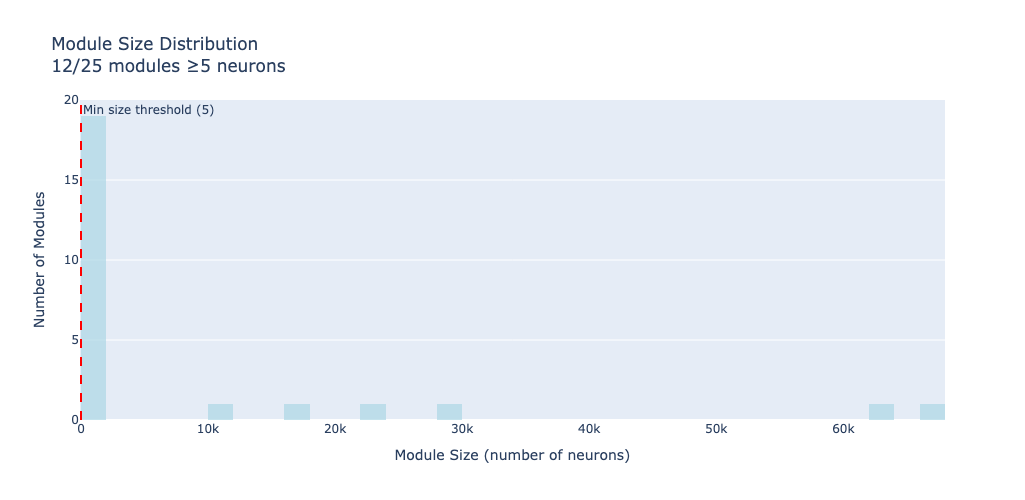


Displaying: Purity Heatmap


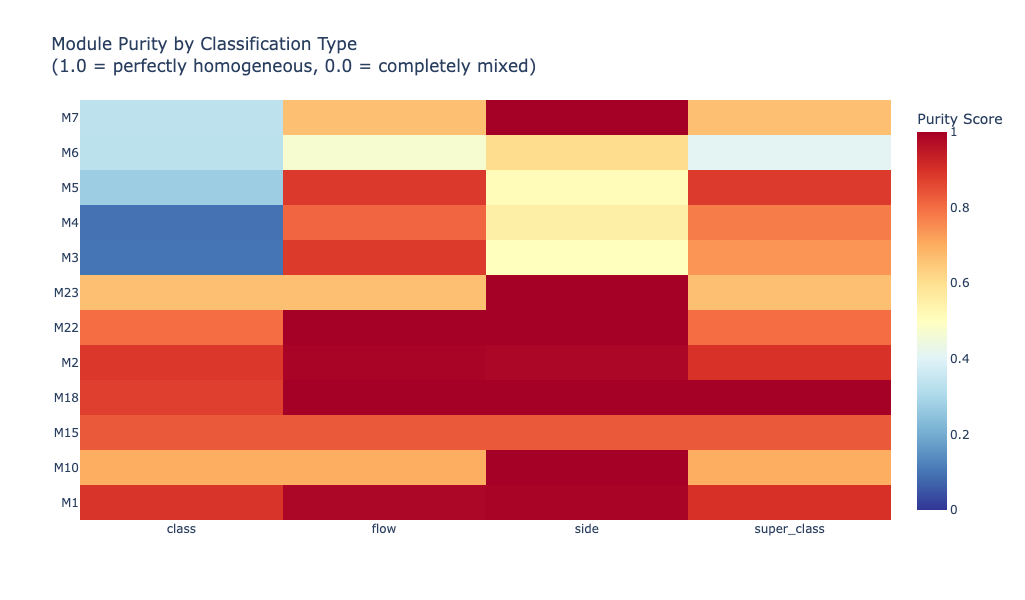


Displaying: Separation Scores


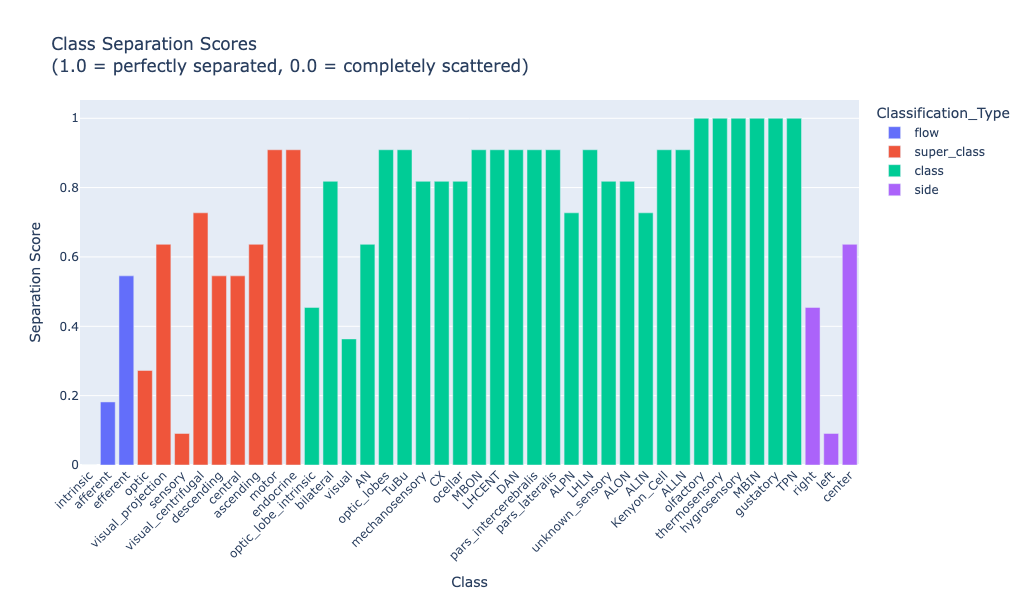


Displaying: Composition by super_class


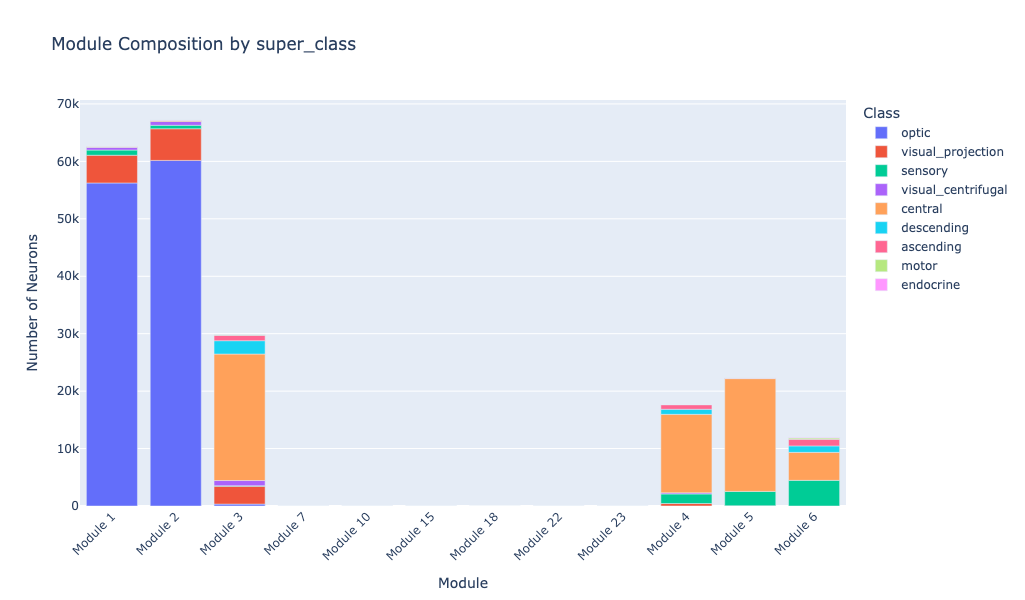


Displaying: Composition by flow


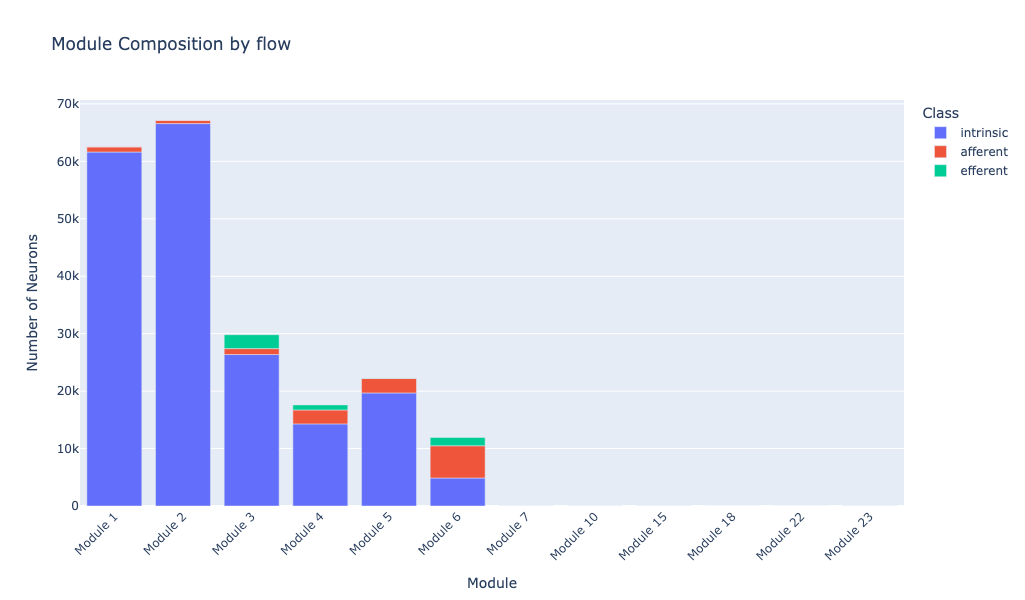


Displaying: Composition by class


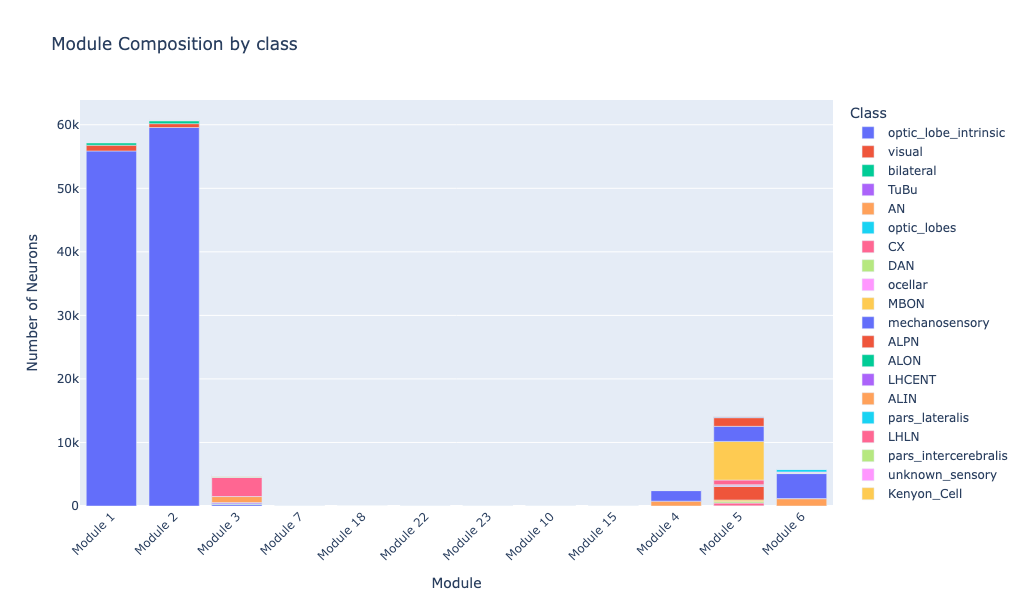


✅ Analysis complete for level_1

ANALYZING LEVEL_2
=== COMMUNITY DETECTION PERFORMANCE REPORT ===

📊 OVERALL STATISTICS:
   Total neurons: 211,346
   Total modules found: 197
   Large modules (≥5 neurons): 196
   Neurons in large modules: 211,342 (100.0%)
   Average module size: 1072.8
   Largest module: 38,073 neurons

🎯 MODULE PURITY SCORES:
   flow: 0.904 average purity
   super_class: 0.820 average purity
   class: 0.162 average purity
   side: 0.758 average purity

🔄 CLASS SEPARATION SCORES:
   flow: 0.361 average separation
   super_class: 0.677 average separation
   class: 0.918 average separation
   side: 0.361 average separation

📈 GENERATING VISUALIZATIONS...

Displaying: Module Size Distribution


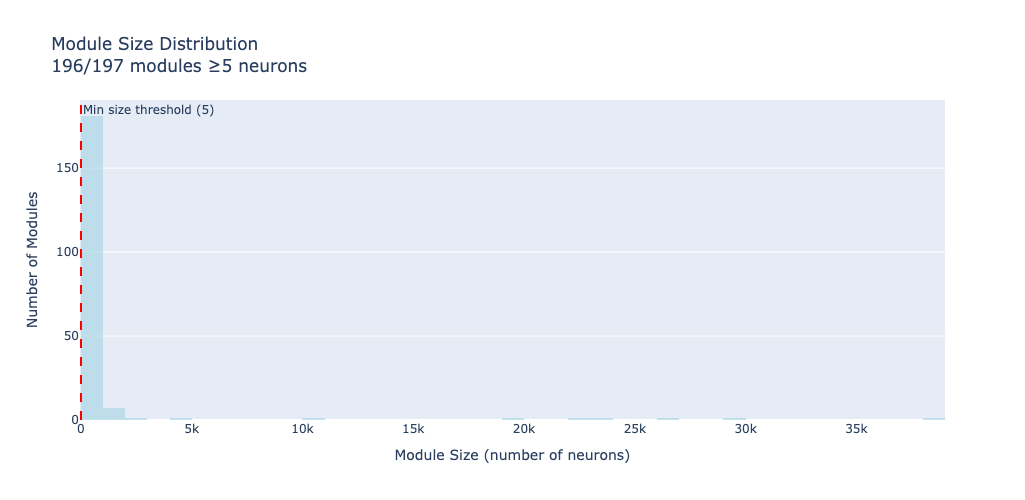


Displaying: Purity Heatmap


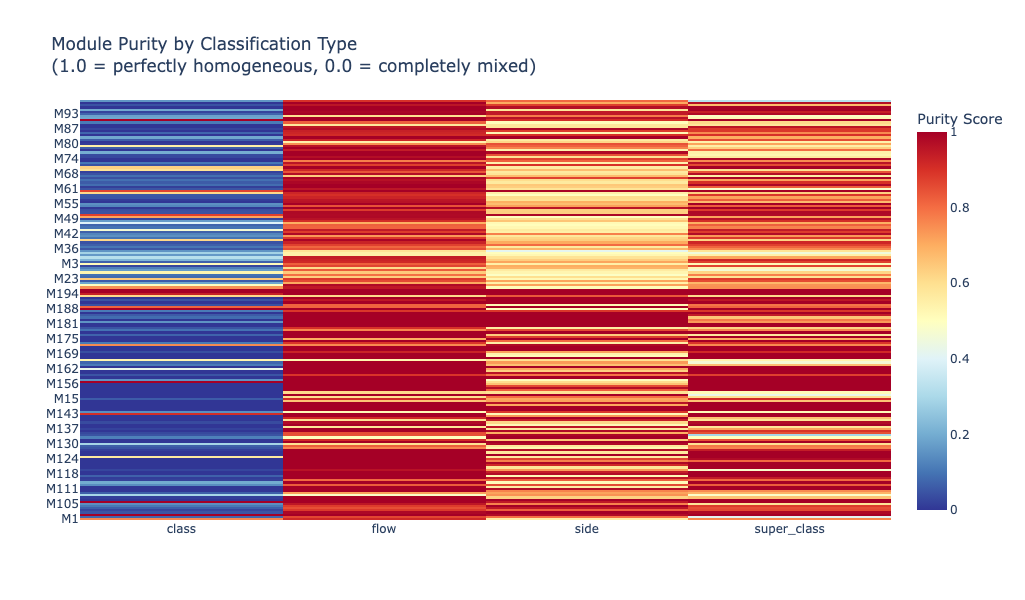


Displaying: Separation Scores


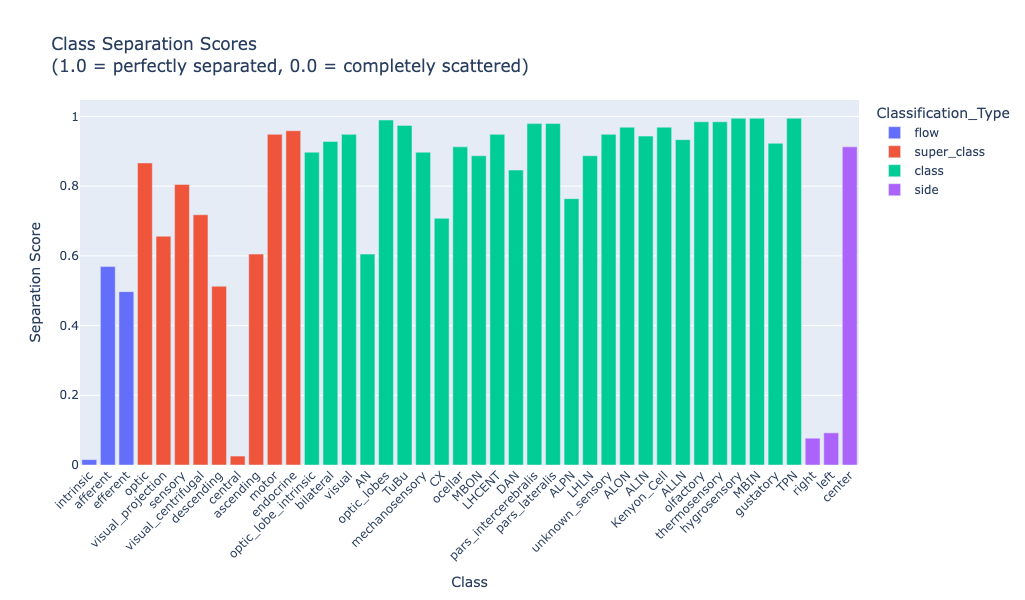


Displaying: Composition by super_class


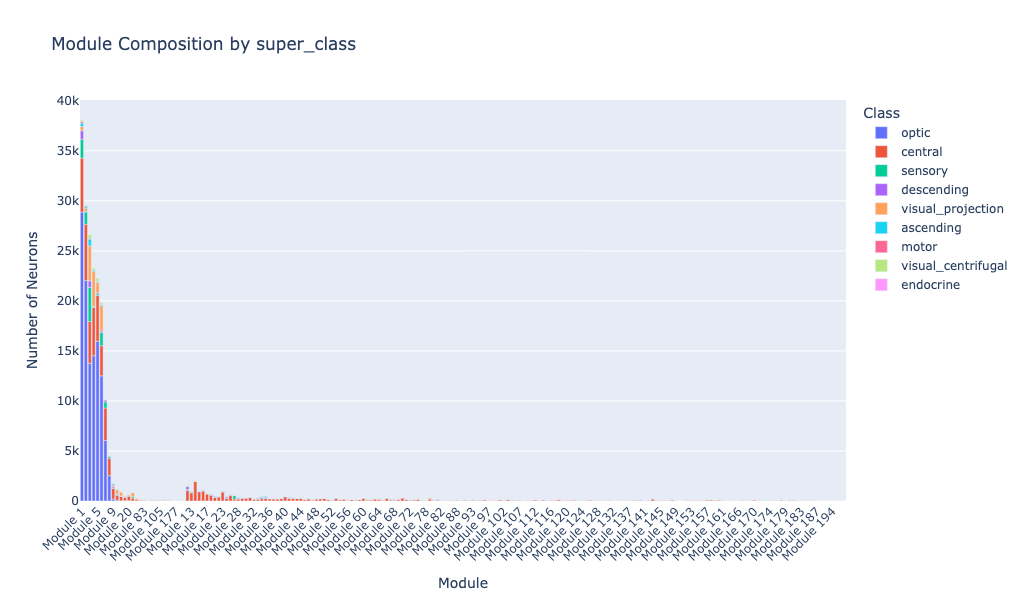


Displaying: Composition by flow


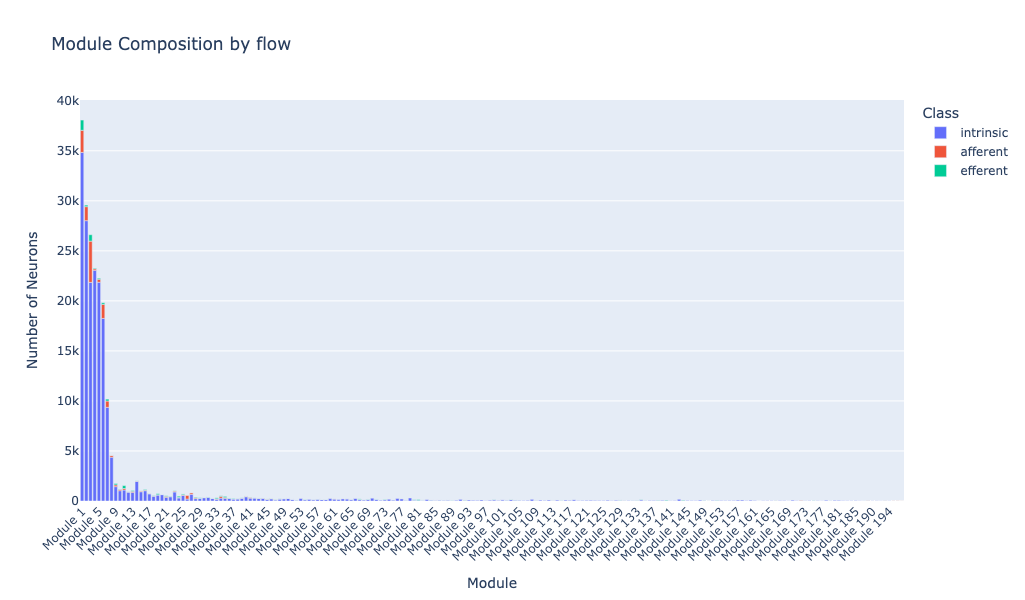


Displaying: Composition by class


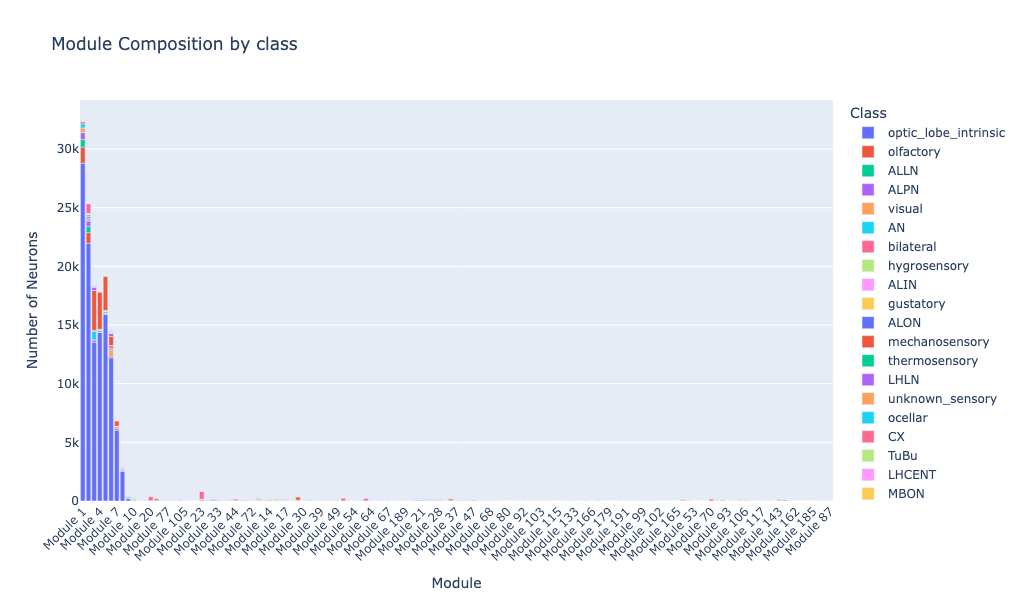


✅ Analysis complete for level_2


In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# ====== SUMMARY ANALYSIS FUNCTIONS ======

def calculate_module_purity(merged_df, module_col, class_col):
    """
    Calculate purity score for each module - how homogeneous each module is
    Purity = (largest class in module) / (total neurons in module)
    """
    purity_scores = {}
    
    for module in merged_df[module_col].dropna().unique():
        module_data = merged_df[merged_df[module_col] == module]
        if len(module_data) == 0:
            continue
            
        class_counts = module_data[class_col].value_counts()
        if len(class_counts) == 0:
            purity_scores[module] = 0
        else:
            largest_class_count = class_counts.iloc[0]
            purity = largest_class_count / len(module_data)
            purity_scores[module] = purity
    
    return purity_scores

def calculate_class_separation(merged_df, module_col, class_col):
    """
    Calculate how well each class is separated into distinct modules
    Separation = 1 - (number of modules containing this class - 1) / (total modules - 1)
    """
    separation_scores = {}
    
    total_modules = len(merged_df[module_col].dropna().unique())
    
    for class_type in merged_df[class_col].dropna().unique():
        class_data = merged_df[merged_df[class_col] == class_type]
        modules_with_class = len(class_data[module_col].dropna().unique())
        
        if total_modules <= 1:
            separation = 1.0
        else:
            separation = 1 - (modules_with_class - 1) / (total_modules - 1)
        
        separation_scores[class_type] = max(0, separation)  # Ensure non-negative
    
    return separation_scores

def create_performance_summary(merged_df, level='level_1'):
    """Create comprehensive performance summary"""
    
    # Filter to large modules only (>=5 neurons)
    module_counts = merged_df[level].value_counts()
    large_modules = module_counts[module_counts >= 5].index
    large_module_data = merged_df[merged_df[level].isin(large_modules)]
    
    results = {}
    
    # Overall statistics
    results['total_neurons'] = len(merged_df)
    results['total_modules'] = len(merged_df[level].dropna().unique())
    results['large_modules'] = len(large_modules)
    results['neurons_in_large_modules'] = len(large_module_data)
    results['pct_in_large_modules'] = len(large_module_data) / len(merged_df) * 100
    
    # Module size statistics
    results['module_sizes'] = module_counts.to_dict()
    results['avg_module_size'] = module_counts.mean()
    results['median_module_size'] = module_counts.median()
    results['largest_module'] = module_counts.iloc[0]
    results['smallest_large_module'] = module_counts[module_counts >= 5].min()
    
    # Purity analysis (for each classification type)
    classification_cols = ['flow', 'super_class', 'class', 'side']
    results['purity'] = {}
    results['separation'] = {}
    
    for class_col in classification_cols:
        if class_col in large_module_data.columns and large_module_data[class_col].notna().sum() > 0:
            purity = calculate_module_purity(large_module_data, level, class_col)
            separation = calculate_class_separation(large_module_data, level, class_col)
            
            results['purity'][class_col] = purity
            results['separation'][class_col] = separation
    
    return results

# ====== VISUALIZATION FUNCTIONS ======

def plot_module_size_distribution(results):
    """Plot module size distribution"""
    sizes = list(results['module_sizes'].values())
    
    fig = go.Figure()
    
    # Histogram
    fig.add_trace(go.Histogram(
        x=sizes,
        nbinsx=50,
        name='All modules',
        opacity=0.7,
        marker_color='lightblue'
    ))
    
    # Mark large modules threshold
    fig.add_vline(x=5, line_dash="dash", line_color="red", 
                  annotation_text="Min size threshold (5)")
    
    fig.update_layout(
        title=f"Module Size Distribution<br>{results['large_modules']}/{results['total_modules']} modules ≥5 neurons",
        xaxis_title="Module Size (number of neurons)",
        yaxis_title="Number of Modules",
        width=800,
        height=500
    )
    
    return fig

def plot_purity_heatmap(results):
    """Plot purity scores as heatmap"""
    if not results['purity']:
        return None
    
    # Prepare data for heatmap
    purity_data = []
    
    for class_col, purity_dict in results['purity'].items():
        for module, purity in purity_dict.items():
            purity_data.append({
                'Module': f"M{module}", 
                'Classification': class_col,
                'Purity': purity
            })
    
    if not purity_data:
        return None
    
    purity_df = pd.DataFrame(purity_data)
    pivot_df = purity_df.pivot(index='Module', columns='Classification', values='Purity')
    
    fig = go.Figure(data=go.Heatmap(
        z=pivot_df.values,
        x=pivot_df.columns,
        y=pivot_df.index,
        colorscale='RdYlBu_r',
        zmin=0,
        zmax=1,
        colorbar=dict(title="Purity Score")
    ))
    
    fig.update_layout(
        title="Module Purity by Classification Type<br>(1.0 = perfectly homogeneous, 0.0 = completely mixed)",
        width=800,
        height=600
    )
    
    return fig

def plot_separation_bars(results):
    """Plot class separation scores"""
    if not results['separation']:
        return None
    
    separation_data = []
    for class_col, sep_dict in results['separation'].items():
        for class_type, separation in sep_dict.items():
            separation_data.append({
                'Classification_Type': class_col,
                'Class': class_type,
                'Separation': separation
            })
    
    if not separation_data:
        return None
    
    sep_df = pd.DataFrame(separation_data)
    
    fig = px.bar(sep_df, 
                 x='Class', 
                 y='Separation', 
                 color='Classification_Type',
                 title="Class Separation Scores<br>(1.0 = perfectly separated, 0.0 = completely scattered)",
                 labels={'Separation': 'Separation Score'})
    
    fig.update_layout(
        width=1000,
        height=600,
        xaxis_tickangle=-45
    )
    
    return fig

def plot_composition_breakdown(merged_df, level='level_1', class_col='super_class'):
    """Plot composition of each large module"""
    
    # Filter to large modules
    module_counts = merged_df[level].value_counts()
    large_modules = module_counts[module_counts >= 5].index
    large_module_data = merged_df[merged_df[level].isin(large_modules)]
    
    if class_col not in large_module_data.columns or large_module_data[class_col].notna().sum() == 0:
        return None
    
    # Create composition data
    composition_data = []
    for module in sorted(large_modules):
        module_data = large_module_data[large_module_data[level] == module]
        class_counts = module_data[class_col].value_counts()
        
        for class_type, count in class_counts.items():
            composition_data.append({
                'Module': f"Module {module}",
                'Class': class_type,
                'Count': count,
                'Percentage': count / len(module_data) * 100
            })
    
    comp_df = pd.DataFrame(composition_data)
    
    fig = px.bar(comp_df, 
                 x='Module', 
                 y='Count', 
                 color='Class',
                 title=f"Module Composition by {class_col}",
                 labels={'Count': 'Number of Neurons'})
    
    fig.update_layout(
        width=1000,
        height=600,
        xaxis_tickangle=-45
    )
    
    return fig

# ====== MAIN ANALYSIS ======

def generate_community_performance_report(merged_df, level='level_1'):
    """Generate complete performance report"""
    
    print("=== COMMUNITY DETECTION PERFORMANCE REPORT ===\n")
    
    # Calculate performance metrics
    results = create_performance_summary(merged_df, level)
    
    # Print summary statistics
    print(f"📊 OVERALL STATISTICS:")
    print(f"   Total neurons: {results['total_neurons']:,}")
    print(f"   Total modules found: {results['total_modules']}")
    print(f"   Large modules (≥5 neurons): {results['large_modules']}")
    print(f"   Neurons in large modules: {results['neurons_in_large_modules']:,} ({results['pct_in_large_modules']:.1f}%)")
    print(f"   Average module size: {results['avg_module_size']:.1f}")
    print(f"   Largest module: {results['largest_module']:,} neurons")
    
    # Print purity scores
    if results['purity']:
        print(f"\n🎯 MODULE PURITY SCORES:")
        for class_col, purity_dict in results['purity'].items():
            avg_purity = np.mean(list(purity_dict.values()))
            print(f"   {class_col}: {avg_purity:.3f} average purity")
    
    # Print separation scores  
    if results['separation']:
        print(f"\n🔄 CLASS SEPARATION SCORES:")
        for class_col, sep_dict in results['separation'].items():
            avg_separation = np.mean(list(sep_dict.values()))
            print(f"   {class_col}: {avg_separation:.3f} average separation")
    
    # Generate plots
    print(f"\n📈 GENERATING VISUALIZATIONS...")
    
    figs = []
    
    # Module size distribution
    fig1 = plot_module_size_distribution(results)
    if fig1:
        figs.append(("Module Size Distribution", fig1))
    
    # Purity heatmap
    fig2 = plot_purity_heatmap(results)
    if fig2:
        figs.append(("Purity Heatmap", fig2))
    
    # Separation bars
    fig3 = plot_separation_bars(results)
    if fig3:
        figs.append(("Separation Scores", fig3))
    
    # Composition breakdown
    for class_col in ['super_class', 'flow', 'class']:
        fig4 = plot_composition_breakdown(merged_df, level, class_col)
        if fig4:
            figs.append((f"Composition by {class_col}", fig4))
    
    return results, figs

# ====== RUN ANALYSIS ======
# Note: This assumes 'merged' DataFrame exists from previous code
# Run this after your main analysis code

try:
    # Analyze both levels
    for level in ['level_1', 'level_2']:
        print(f"\n{'='*60}")
        print(f"ANALYZING {level.upper()}")
        print(f"{'='*60}")
        
        results, figures = generate_community_performance_report(merged, level)
        
        # Display figures
        for title, fig in figures:
            print(f"\nDisplaying: {title}")
            fig.show()
        
        print(f"\n✅ Analysis complete for {level}")

except NameError:
    print("❌ Please run the main community detection code first to create the 'merged' DataFrame")